# Create train-test-validation splits (for promiscuous esterases)

Here, I basically do the same as in N2_curate_training_data.ipynb but I do it for the combined training and validation data to later make my own train-test splits. 

In [1]:
import pandas as pd

df_train = pd.read_csv('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_train.csv')
df_valid = pd.read_csv('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_valid.csv',  low_memory=False)
df_protein = pd.read_pickle('/home/helen/cec_degrader/generalize/data/protein.pkl')

# Combine validation and training data
df_CAGE = pd.concat([df_train, df_valid], axis=0).reset_index(drop=True)

### Filter down to all promiscuous enzymes

In [ ]:
# Positive samples only
df = df_CAGE[df_CAGE['Label'] == 1]

# Add EC number from protein.pkl if not present 
ec_mapping = df_protein.groupby('Entry')['EC number'].apply(list).to_dict()
df['EC number'] = df['UniprotID'].map(ec_mapping)
df['EC number'] = df['EC number'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Filter to (catalytically) promiscuous enzymes (i.e. present more than once in df)
filtered_df = df[df['UniprotID'].duplicated(keep=False)]
df  = filtered_df.sort_values(by='UniprotID')
df = df.reset_index(drop=True)

# Split reaction SMILEs into substrates and products
df[['substrates', 'products']] = df['SMILES'].str.split('>>', expand=True)

# Remove H20 and H+ as a substrate
def remove_water_and_protons(smiles):
    if pd.isna(smiles):
        return smiles
    parts = smiles.split('.')
    parts = [p for p in parts if p not in ('[H]O[H]', '[H+]', '[H]')]
    return '.'.join(parts)

# Number of substrates and products per entry
df['number_substrates'] = df['substrates'].str.count('\.') + 1
df['number_products'] = df['products'].str.count('\.') + 1

### Filter down to all substrate promiscuous enzymes

In [3]:

# Create cannonical substrate strings to detect duplicate substrates 
def canonical_substrates(substrates):
    parts = substrates.split('.')
    parts = sorted([p.strip() for p in parts])
    return '.'.join(parts)

df['substrates_canonical'] = df['substrates'].str.strip().apply(canonical_substrates)

# For each UniprotID, remove catalytically promiscuous enzymes by filtering out rows with identical substrates
def filter_unique_substrates(group):
    counts = group['substrates_canonical'].value_counts()
    unique_substrates = counts[counts == 1].index
    return group[group['substrates_canonical'].isin(unique_substrates)]

df_unique = df.groupby('UniprotID', group_keys=False).apply(filter_unique_substrates).reset_index(drop=True)
df_unique = df_unique.drop(columns=['substrates_canonical'])
df_unique = df_unique[df_unique['UniprotID'].duplicated(keep=False)]
df_unique = df_unique.sort_values(by='UniprotID')

# Split substrate SMILES into seperate entries
df_unique['substrates_split'] = df_unique['substrates'].str.split('.')
df_unique = df_unique.explode('substrates_split').reset_index(drop=True)
df_unique.loc[df_unique['number_substrates'] > 1]

# For each UniprotID, remove the substrates that are common to all RHEA_IDs within the same UniprotID. The logic being that these do not contribute to promiscuity because stay constant in all reactions. 
substrate_rhea_counts = df_unique.groupby(['UniprotID', 'substrates_split'])['RHEA_ID'].nunique().reset_index(name='rhea_count')
total_rhea_counts = df_unique.groupby('UniprotID')['RHEA_ID'].nunique().reset_index(name='total_rhea_count') # Find the total number of unique RHEA_IDs for each UniprotID
merged = pd.merge(substrate_rhea_counts, total_rhea_counts, on='UniprotID')
merged['appear_in_all_rhea'] = merged['rhea_count'] == merged['total_rhea_count']
substrates_to_remove = merged[merged['appear_in_all_rhea'] == True]

df_filtered = df_unique.merge(substrates_to_remove[['UniprotID', 'substrates_split']], 
                       on=['UniprotID', 'substrates_split'], how='left', indicator=True)

df = df_filtered[df_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])

# 132'620 entries

### Filder down to promiscous esterases with EC 3.1.

In [4]:
import pandas as pd

# Filter to only promiscuous esterases
uniprot_with_3_1 = df.loc[df['EC number'].fillna('').str.startswith('3.1.'), 'UniprotID'].unique()
df_filtered = df[df['UniprotID'].isin(uniprot_with_3_1)].copy()
df_filtered = df_filtered.reset_index(drop=True)
#df_filtered.to_pickle('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_train_valid_promiscuous_substrates_EC3p1.pkl')

# 10'354   entries
# Contains all substrate promiscuous enzymes with EC 3.1 having removed catalytically promiscuous enzymes. 

### Run MMSeqs2 on promiscuous esterases

In [ ]:
import sys
sys.path.append('/home/helen/enzyme-tk/enzymetk')
from enzymetk.similarity_mmseqs_step import MMseqs
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environment
df_promis_esterases = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/data/EnzymeCAGE_train_valid_promiscuous_substrates_EC3p1.pkl')
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'mmseqs2/'

df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.5', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_train_valid_mmseqs2_0p5_similarity.pkl'))
df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.3', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_train_valid_mmseqs2_0p3_similarity.pkl'))

In [ ]:
# Integrate mmseqs2 results into one df
import pandas as pd

df_mmseqs2_0p5 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_train_valid_mmseqs2_0p5_similarity.pkl')
df_mmseqs2_0p3 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_train_valid_mmseqs2_0p3_similarity.pkl')

df_mmseqs2_0p5 = df_mmseqs2_0p5.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p5_similarity'})
df_mmseqs2_0p3 = df_mmseqs2_0p3.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p3_similarity'})

# Keep only one representative cluster per UniprotID for merge purposes
df_mmseqs2_0p3_dedup = df_mmseqs2_0p3.drop_duplicates(subset='UniprotID')

df_mmseqs2 = df_mmseqs2_0p5.merge(
    df_mmseqs2_0p3_dedup[['UniprotID', 'mmseqs_representative_cluster_seq_0p3_similarity']],
    on='UniprotID', how='left')

#df_mmseqs2.to_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_train_valid_all.pkl')

### Split into train-test sets

In [67]:
import random 

def create_train_test_splits(df, cluster_col: str, train_size: float): 
    df = df.copy() 
    
    clustered_groups = df.groupby(cluster_col)
    all_clusters = list(clustered_groups.groups.keys())

    random.seed(42)
    random.shuffle(all_clusters)
    n_total = len(all_clusters)
    n_train = int(n_total * train_size)
    train_clusters = all_clusters[:n_train]
    test_clusters = all_clusters[n_train:]

    df['split'] = 'none'
    df.loc[df[cluster_col].isin(train_clusters), 'split'] = 'train'
    df.loc[df[cluster_col].isin(test_clusters), 'split'] = 'test'
    print(df['split'].value_counts())

    return df

df = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_train_valid_all.pkl')
df_train_test_0p5_similarity = create_train_test_splits(df, cluster_col='mmseqs_representative_cluster_seq_0p5_similarity', train_size=0.8)
df_train_test_0p3_similarity = create_train_test_splits(df, cluster_col='mmseqs_representative_cluster_seq_0p3_similarity', train_size=0.8)

#df_train_test_0p5_similarity.to_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_train_test_0p5_similarity_splits.pkl')
#df_train_test_0p3_similarity.to_pickle('/nvme2/helen/masterthesis/manuscript/trainingdata/promiscuous_esterases_train_test_0p3_similarity_splits.pkl')


train    7918
test     2436
Name: split, dtype: int64
train    8813
test     1541
Name: split, dtype: int64


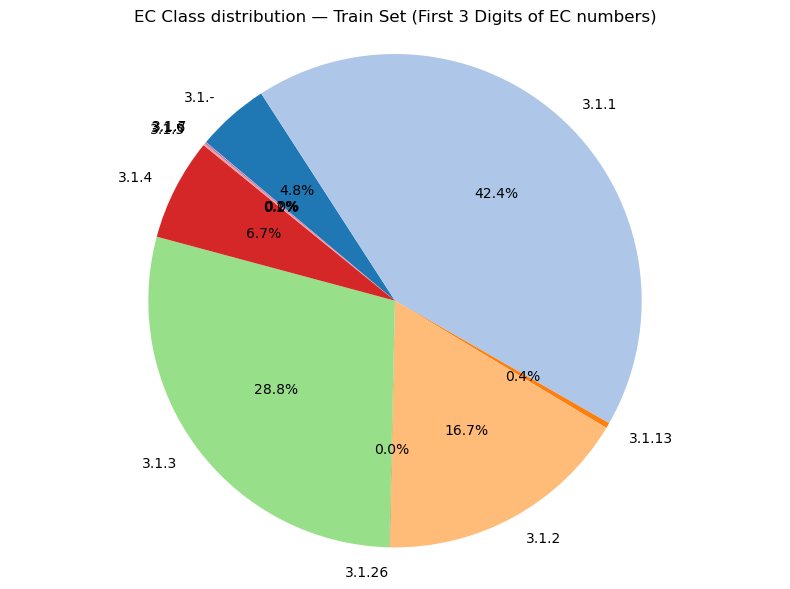

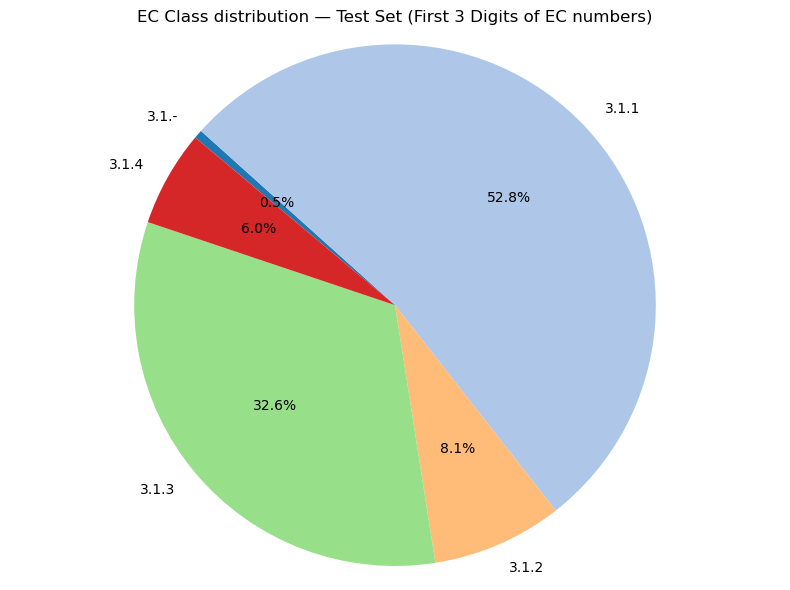

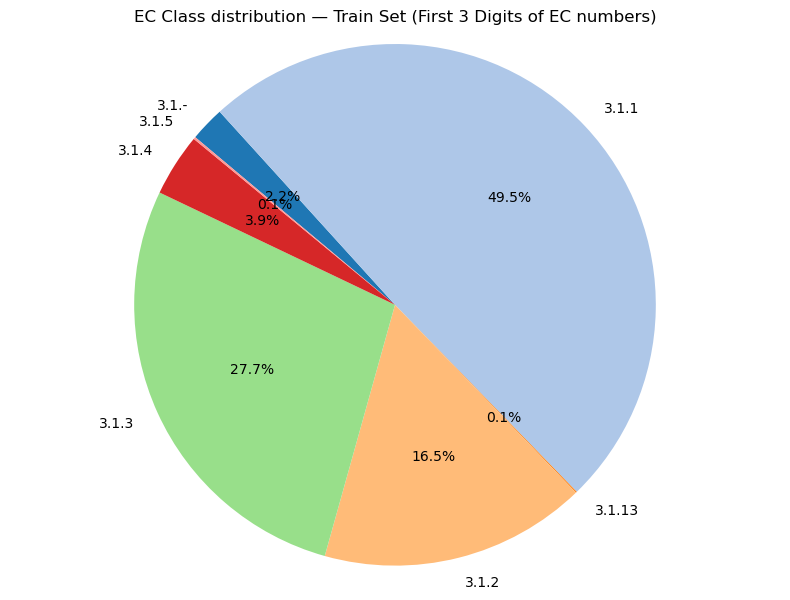

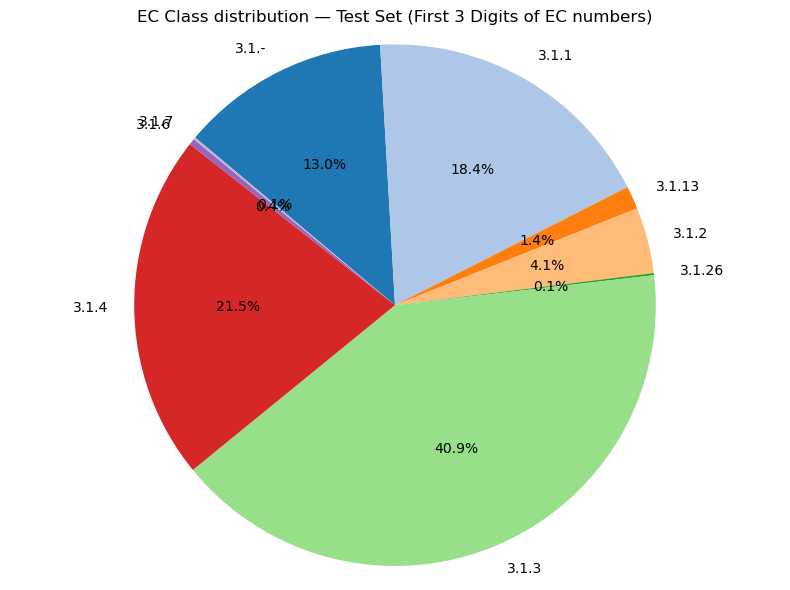

In [57]:
# Plot pie-charts of EC class distribution
import pandas as pd
import matplotlib.pyplot as plt

def plot_ec_class_pie_chart(df, ec_column='EC number', split_column='split', ec_level=3, title='EC Class Distribution'):
    """
    Plots a pie chart of enzyme counts grouped by the first `ec_level` digits of EC numbers.
    """
    df = df[df[ec_column].notna()]

    # Extract EC prefix
    df['EC_prefix'] = df[ec_column].apply(
        lambda x: '.'.join(x.split('.')[:ec_level]) if isinstance(x, str) else None
    )
    
    # Determine all unique EC classes across the entire dataset
    all_ec_classes = sorted(df['EC_prefix'].dropna().unique())

    # Assign consistent colors
    cmap = plt.get_cmap('tab20')  # or another color map
    color_map = {ec: cmap(i % 20) for i, ec in enumerate(all_ec_classes)}

    # Plot pie charts for each split
    for split_value in df[split_column].unique():
        df_split = df[df[split_column] == split_value]
        ec_counts = df_split['EC_prefix'].value_counts().sort_index()

        ec_labels = [ec for ec in all_ec_classes if ec in ec_counts.index]
        sizes = [ec_counts[ec] for ec in ec_labels]
        colors = [color_map[ec] for ec in ec_labels]

        plt.figure(figsize=(8, 6))
        plt.pie(
            ec_counts,
            labels=ec_labels,
            colors = colors, 
            autopct='%1.1f%%',
            startangle=140,
            counterclock=False
        )
        plt.title(f"{title} — {split_value.capitalize()} Set (First {ec_level} Digits of EC numbers)")
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

plot_ec_class_pie_chart(df_train_test_0p5_similarity, ec_column='EC number', ec_level=3, title = 'EC Class distribution')
plot_ec_class_pie_chart(df_train_test_0p3_similarity, ec_column='EC number', ec_level=3, title = 'EC Class distribution')

### Split into train-test sets using stratified splitting according to EC number

/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


train    8332
test     2022
Name: split, dtype: int64
train    8152
test     2202
Name: split, dtype: int64


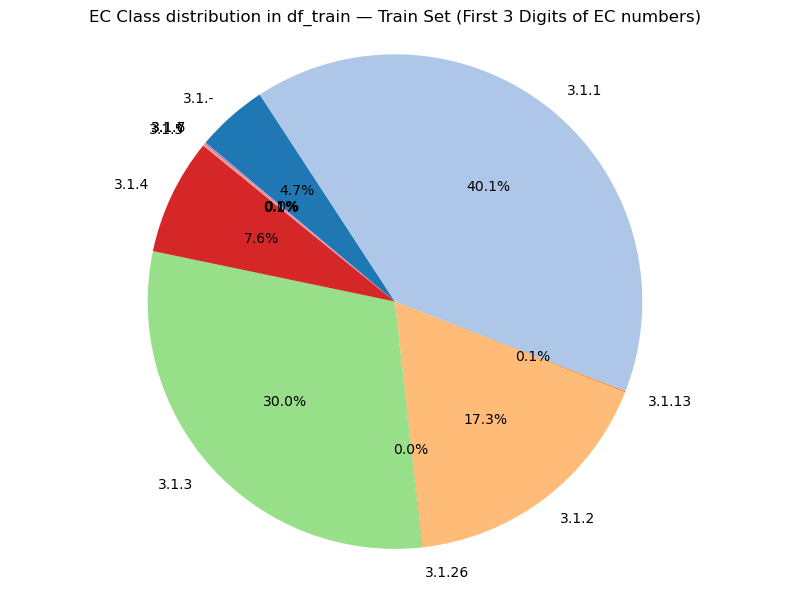

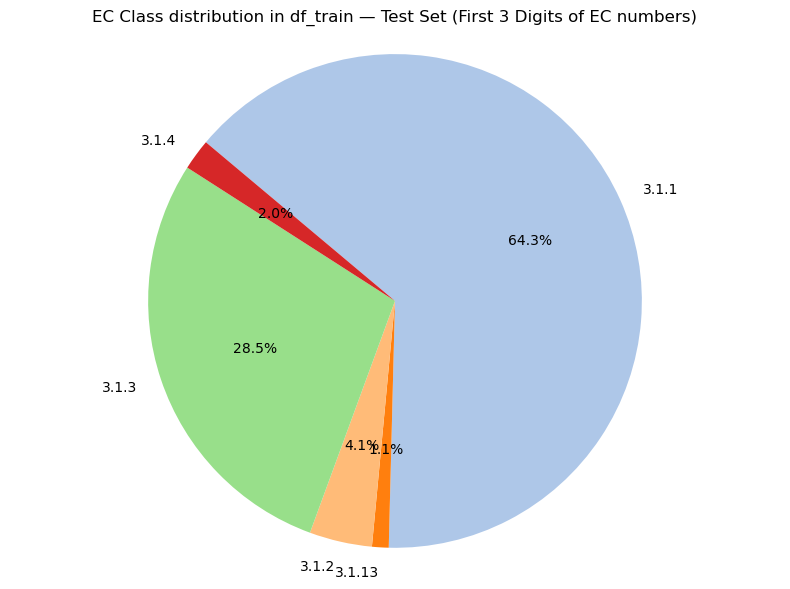

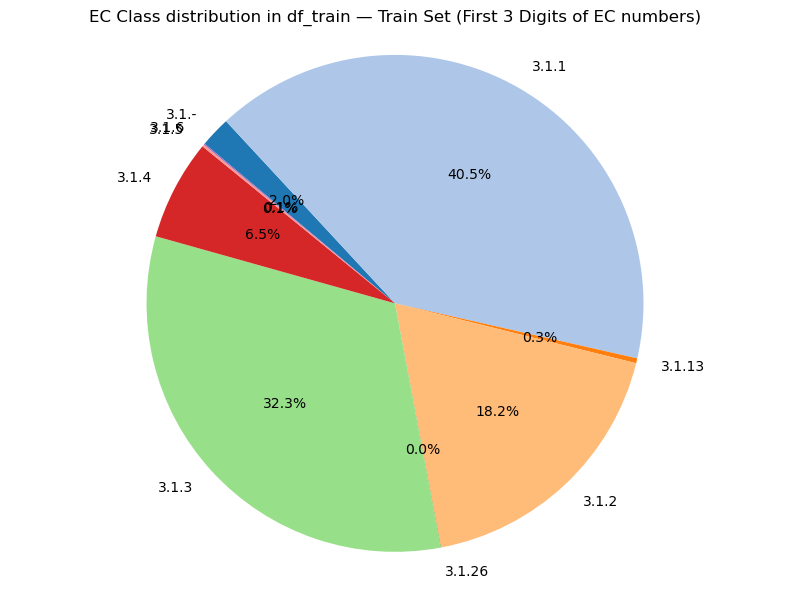

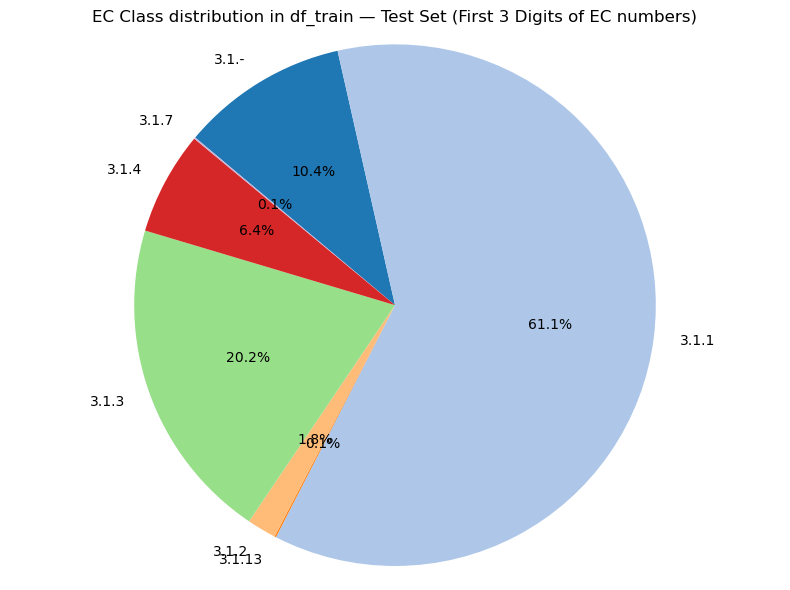

In [58]:
from sklearn.model_selection import StratifiedGroupKFold
import pandas as pd



def stratified_train_test_splits(df, cluster_col, label_col, train_size=0.8, random_state=42):
    df = df.copy() 
    
    sgkf = StratifiedGroupKFold(n_splits=int(1 / (1-train_size)), shuffle=True, random_state=random_state)

    for train_idx, test_idx in sgkf.split(df, y=df[label_col], groups=df[cluster_col]):
        df['split'] = 'none'
        df.loc[train_idx, 'split'] = 'train'
        df.loc[test_idx, 'split'] = 'test'
        print(df['split'].value_counts())
        break  # only take the first split

    return df

df_train_test_0p5_similarity = stratified_train_test_splits(df, label_col='EC number', cluster_col='mmseqs_representative_cluster_seq_0p5_similarity', train_size=0.8)
df_train_test_0p3_similarity = stratified_train_test_splits(df, label_col='EC number', cluster_col='mmseqs_representative_cluster_seq_0p3_similarity', train_size=0.8)

plot_ec_class_pie_chart(df_train_test_0p5_similarity, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_train')
plot_ec_class_pie_chart(df_train_test_0p3_similarity, ec_column='EC number', ec_level=3, title = 'EC Class distribution in df_train')

### Distribution of number of substrates over EC classes

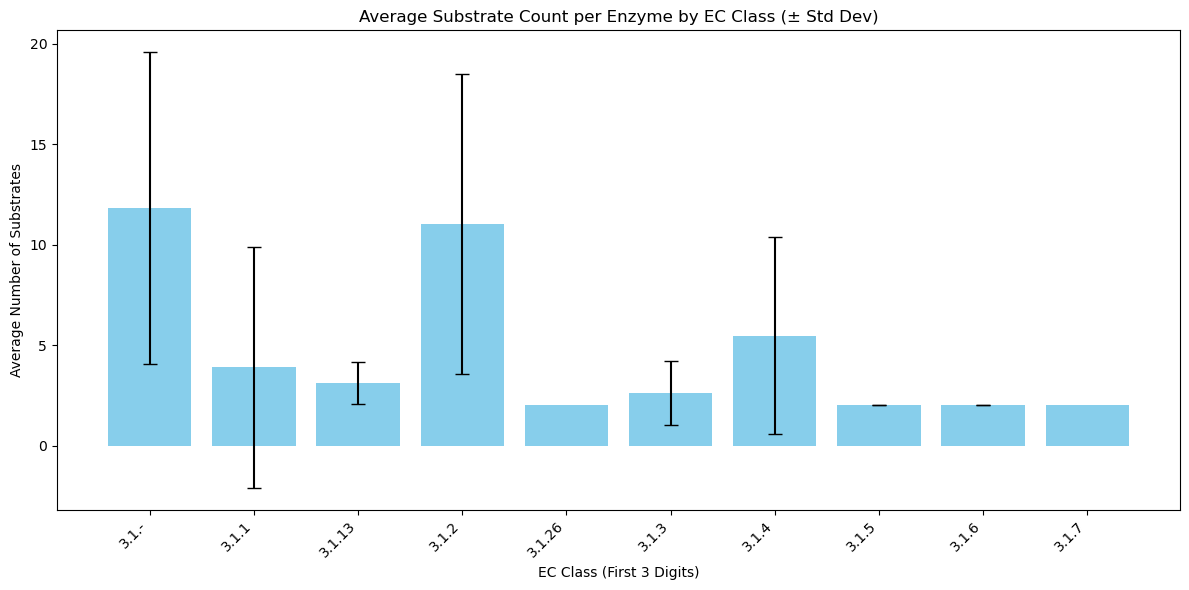

In [65]:
import matplotlib.pyplot as plt

# Number of substrates per UniprotID
substrate_counts = df.groupby('UniprotID').size().reset_index(name='n_substrates')
df_ec = df[['UniprotID', 'EC number']].drop_duplicates()
df_ec['EC_prefix'] = df_ec['EC number'].apply(
    lambda x: '.'.join(x.split('.')[:3]) if isinstance(x, str) else None
)

df_merged = df_ec.merge(substrate_counts, on='UniprotID')
ec_stats = df_merged.groupby('EC_prefix')['n_substrates'].agg(['mean', 'std', 'count']).reset_index()

plt.figure(figsize=(12, 6))
plt.bar(ec_stats['EC_prefix'], ec_stats['mean'], yerr=ec_stats['std'], capsize=5, color='skyblue')
plt.ylabel('Average Number of Substrates')
plt.xlabel('EC Class (First 3 Digits)')
plt.title('Average Substrate Count per Enzyme by EC Class (± Std Dev)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
